<a href="https://colab.research.google.com/github/ssegovba/identifying-deforestation/blob/main/notebooks/cnn_custom_model_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model on Amazon Rainforest Data for Deforestation Tracking
*Santiago Segovia*

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing import image
import os

from google.colab import drive

In [2]:
# Mount GDrive
drive.mount("/content/drive")

Mounted at /content/drive


## 0. Initial Setup

In [51]:
  train_model = False
  small_train = True
  img_size = (150, 150)
  if small_train:
      num_obs_use = 40000
      model_name = 'best_model_' + str(int(num_obs_use/1000)) + 'K_sample.keras'
  else:
      model_name = 'best_model_full_sample.keras'

  data_path = "/content/drive/Shareddrives/computer-vision-project/Data"
  train_path = "/content/drive/Shareddrives/computer-vision-project/Data/train-jpg"
  test_path = "/content/drive/Shareddrives/computer-vision-project/Data/test-jpg"
  model_path = "/content/drive/Shareddrives/computer-vision-project/Models/"

## I. Data Pre-processing

### I.a Handling the Labels

We begin by loading the metadata that has the names of the labels:



In [4]:
# Load the CSV file with the metadata
labels_df = pd.read_csv(data_path + '/train_classes.csv')

# Add extension so image names match file names
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: x + '.jpg')

# Convert the space-separated tags into a list of tags
labels_df['tags'] = labels_df['tags'].apply(lambda x: x.split())

In [ ]:
labels_df.head()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


Since we have 17 different labels, we reduce the number of classes by grouping all human-made changes under the "human" tag:

In [5]:
human_tags = ['agriculture', 'road', 'habitation', 'cultivation', 'slash_burn',
              'selective_logging', 'conventional_mine', 'artisinal_mine']

def categorize_tags(tags):
    if any(tag in human_tags for tag in tags):
        return ['human'] + [tag for tag in tags if tag not in human_tags]
    else:
        return tags

labels_df['tags'] = labels_df['tags'].apply(categorize_tags)

In [6]:
# Use a MultiLabelBinarizer for the tags for model training
mlb = MultiLabelBinarizer()
labels_df['encoded_tags'] = list(mlb.fit_transform(labels_df['tags']))

In [7]:
labels_df.head()

,image_name,tags,encoded_tags
0,train_0.jpg,"[haze, primary]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
1,train_1.jpg,"[human, clear, primary, water]","[0, 0, 0, 1, 0, 0, 1, 0, 1, 1]"
2,train_2.jpg,"[clear, primary]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]"
3,train_3.jpg,"[clear, primary]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]"
4,train_4.jpg,"[human, clear, primary]","[0, 0, 0, 1, 0, 0, 1, 0, 1, 0]"


Finally, we subset the number of observations so our model runs faster:

In [8]:
if small_train:
    labels_df = labels_df[:num_obs_use]

### I.b Setting up `ImageDataGenerator` and data generators

Keras provides `ImageDataGenerator` for data augmentation and to streamline the process of loading and preprocessing images. Here, we will use it to normalize images and set up the training and test data generators.

In [49]:
# Initialize the ImageDataGenerator with any specific augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation set (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

We also define a function to load individual images based on `labels_df`:

In [50]:
batch_size = 200

def fetch_images_and_labels(dataset, is_val_data, directory, batch_size=batch_size, img_target_size=img_size):
    n = len(dataset)
    while True:
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_images = []
            batch_labels = []
            # Processing of each image in the batch
            for _, row in dataset.iloc[start:end].iterrows():
                file_path = os.path.join(directory, row['image_name'])
                try:
                    img = image.load_img(file_path, target_size=img_target_size)
                    img_array = image.img_to_array(img)
                    batch_images.append(img_array)
                    batch_labels.append(row['encoded_tags'])
                except FileNotFoundError:
                    continue

            # Only proceed if there are images in the batch
            if len(batch_images) > 0:
                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)

                # Apply transformations and yield
                if is_val_data:
                    yield batch_images, batch_labels
                else:
                    yield train_datagen.flow(batch_images, batch_labels,
                                            batch_size=batch_size).next()

Since we only have labels for the train dataset, we need to split the data between train and validation before creating the data generators so we can measure our model's performance:

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data
train_data, val_data = train_test_split(labels_df, test_size=0.2, random_state=42)

# Number of images per dataset
print("Images in train dataset:", len(train_data))
print("Images in validation dataset:", len(val_data))

# Creating data generators for train and validation datasets
train_generator = fetch_images_and_labels(train_data, False, train_path, batch_size=batch_size, img_target_size=img_size)
val_generator = fetch_images_and_labels(val_data, True, train_path, batch_size=batch_size, img_target_size=img_size)

Images in train dataset: 32000
Images in validation dataset: 8000


## II. Data Modelling

### II.a Define CNN Custom Model

We begin by defining a simple architecture to try the model's performance:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import f1_score

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[1], img_size[2], 3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.20),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# New model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[1], img_size[2], 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Callback for EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

# Callback for Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * np.exp(-0.1)

learning_rate_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Callback for ModelCheckpoint (save the best model only)
model_checkpoint = ModelCheckpoint(
    model_path + model_name,
    monitor='val_loss',  # Metric to monitor
    save_best_only=True, # Only save a model if `val_loss` has improved
    verbose=1
)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 148, 148, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
# Adjust steps based on data size and batch size
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

# Fit the model using the generator
if train_model:
    model.fit(train_generator,
              steps_per_epoch=steps_per_epoch,
              validation_data=val_generator,
              validation_steps=validation_steps,
              epochs=15,
              callbacks=[early_stopping, learning_rate_scheduler, model_checkpoint])
else:
    print("The train_model parameter is set to False. No training is happening.")


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
40/40 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.5610 
Epoch 1: val_loss improved from inf to 210.89549, saving model to /content/drive/Shareddrives/computer-vision-project/Models/best_model_10K_sample.keras
40/40 [==============================] - 2413s 62s/step - loss: 0.6641 - accuracy: 0.5610 - val_loss: 210.8955 - val_accuracy: 0.0405 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
40/40 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.4985
Epoch 2: val_loss improved from 210.89549 to 163.12483, saving model to /content/drive/Shareddrives/computer-vision-project/Models/best_model_10K_sample.keras
40/40 [==============================] - 22s 551ms/step - loss: 0.4283 - accuracy: 0.4985 - val_loss: 163.1248 - val_accuracy: 0.0405 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learn

### II.b Evaluation Metrics

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load the stored model
model = load_model(model_path + 'best_model_10K_sample.keras')

In [48]:
# Collect all predictions and true labels
all_labels = []
all_predictions = []

counter = 0
for images, labels in val_generator:
    preds = model.predict(images)
    counter += len(images)  # Count the actual number of images processed
    print(f"Batch {counter//128 + 1} processed, Batch size: {len(images)}")
    all_predictions.extend(preds)
    all_labels.extend(labels)
    if counter >= len(val_data):
        break

print(f"Total images processed: {counter}")

# Convert predictions and labels to binary format
all_labels = np.array(all_labels)
all_predictions = np.round(np.array(all_predictions))

NameError: name 'val_generator' is not defined

In [ ]:
# Calculate and print metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=mlb.classes_))

Classification Report:
                   precision    recall  f1-score   support

      agriculture       0.00      0.00      0.00       493
   artisinal_mine       0.01      1.00      0.02        13
      bare_ground       0.06      0.56      0.11        34
         blooming       0.01      0.94      0.02        17
        blow_down       0.00      0.00      0.00         2
            clear       1.00      0.01      0.01      1175
           cloudy       0.06      1.00      0.11        96
conventional_mine       0.03      0.50      0.05         4
      cultivation       0.00      0.00      0.00       208
       habitation       0.20      0.08      0.12       144
             haze       0.00      0.00      0.00       120
    partly_cloudy       0.80      0.17      0.28       270
          primary       1.00      0.00      0.00      1524
             road       0.18      0.02      0.03       330
selective_logging       0.00      0.00      0.00        19
       slash_burn       0.01    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## III. Testing the model

Now, we'll use our model to check the results on some untagged images. We begin by defining a function that loads a small batch of test images:

In [34]:
# Function to load and preprocess the test images
def load_test_images(directory, num_img_load, img_target_size=(150,150)):
    images = []
    filenames = os.listdir(directory)
    filenames = filenames[:num_img_load]
    for filename in filenames:
        file_path = os.path.join(directory, filename)
        img = image.load_img(file_path, target_size=img_target_size)
        img_array = image.img_to_array(img)
        images.append(img_array)
    images = np.array(images)
    images /= 255.0  # Ensure you rescale similarly to your training data
    return images, filenames

Now, we load the images and predict the labels:

In [ ]:
# Load test images
test_images, test_filenames = load_test_images(test_path, 12)

In [35]:
# Predicting the labels
predictions = model.predict(test_images)

1/1 [==============================] - 0s 223ms/step


The `predictions` element is a 2D array where the number of rows is the number of test images and the number of columns the probability score for each one of the classes:

In [42]:
predictions.shape

(12, 10)

We create a function that assigns the labels based on a specific threshold. By default, we define the `threshold` as 0.5. In this sense, any class with a probability higher than 0.5 will be used as a tag for an image:

In [46]:
# Function to convert predictions to tags
def predictions_to_tags(predictions, threshold=0.5):
    tag_lists = []
    for prediction in predictions:
        tags = [mlb.classes_[i] for i, value in enumerate(prediction) if value > threshold]
        tag_lists.append(tags)
    return tag_lists

# Convert predictions to tags
predicted_tags = predictions_to_tags(predictions)

# Print filenames and their predicted tags
for filename, tags in zip(test_filenames, predicted_tags):
    print(filename, ": ", tags)

test_28.jpg :  ['clear', 'primary']
test_4.jpg :  ['haze', 'primary']
test_7.jpg :  ['haze', 'primary']
test_1.jpg :  ['clear', 'primary']
test_2.jpg :  ['clear', 'primary']
test_16.jpg :  ['clear', 'primary']
test_41.jpg :  ['clear', 'primary']
test_40.jpg :  ['clear', 'primary']
test_21.jpg :  ['haze', 'primary']
test_31.jpg :  ['haze', 'primary']
test_26.jpg :  ['clear', 'primary']
test_46.jpg :  ['haze', 'primary']


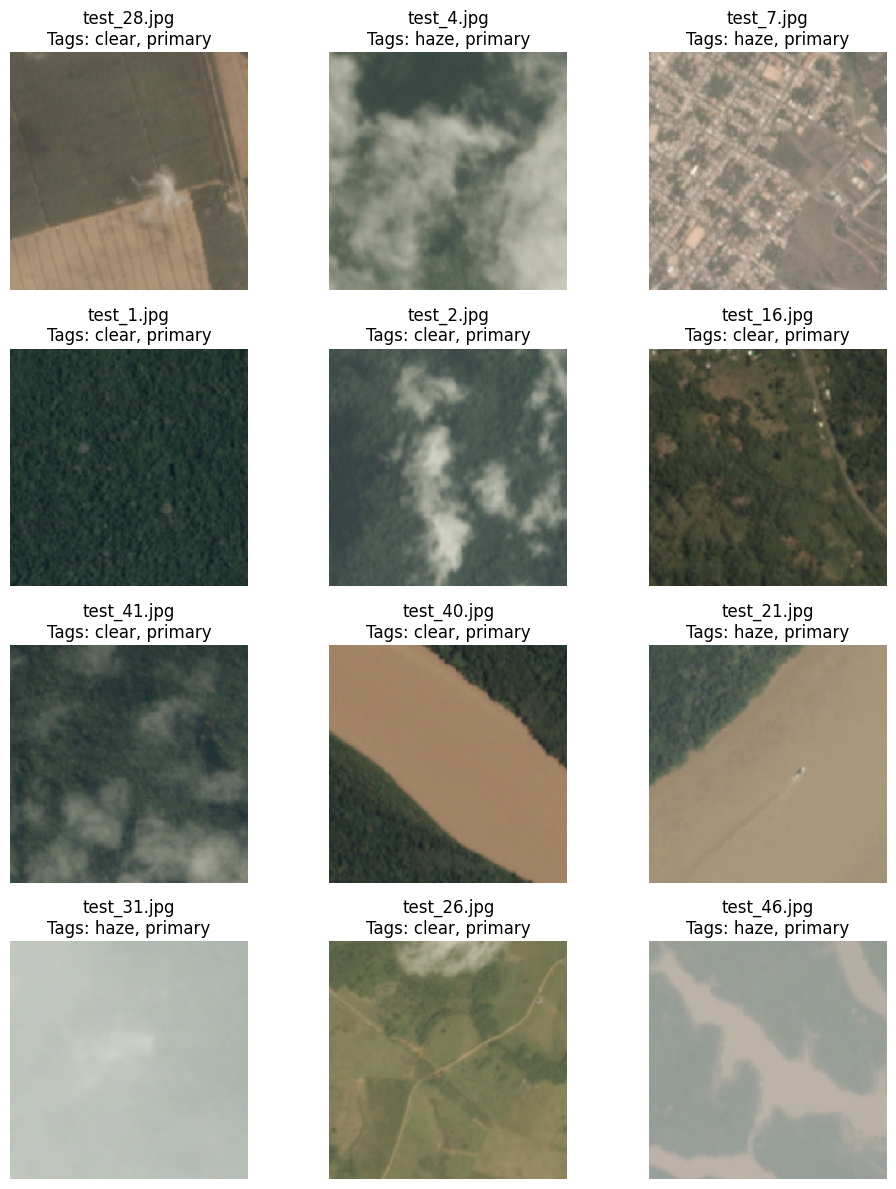

In [47]:
# Function to plot images and their predicted tags
def plot_images_with_tags(images, filenames, predicted_tags, img_per_row=3):
    num_images = len(images)
    num_rows = (num_images + img_per_row - 1) // img_per_row

    # Adjust figsize here (width, height) in inches
    fig, axes = plt.subplots(num_rows, img_per_row, figsize=(10, num_rows * 3))  # Smaller figure size
    axes = axes.flatten()

    for i, (img, filename, tags) in enumerate(zip(images, filenames, predicted_tags)):
        axes[i].imshow(img)
        axes[i].set_title(f"{filename}\nTags: {', '.join(tags)}")
        axes[i].axis('off')

    # Hide any unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plotting the images with their tags
plot_images_with_tags(test_images, test_filenames, predicted_tags)